## LSTM 신경망 훈련하기
IMDB 리뷰 데이터를 사용하기(500개의 단어)

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

2024-04-09 20:06:15.883052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 20:06:15.909681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 20:06:16.307139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [5]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=500, output_dim=16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/home/leejieun/miniforge3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:82: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


작은 셀이 4개 있으므로 SimpleRNN 의 4배인 800개의 파라미터

In [6]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

컴파일 및 훈련해보기

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])   

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5386 - loss: 0.6926 - val_accuracy: 0.5714 - val_loss: 0.6916
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5868 - loss: 0.6910 - val_accuracy: 0.6104 - val_loss: 0.6893
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6227 - loss: 0.6881 - val_accuracy: 0.6350 - val_loss: 0.6839
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6500 - loss: 0.6807 - val_accuracy: 0.6744 - val_loss: 0.6674
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6820 - loss: 0.6541 - val_accuracy: 0.7122 - val_loss: 0.5916
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7211 - loss: 0.5739 - val_accuracy: 0.7400 - val_loss: 0.5503
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7478 - loss: 0.5382 - val_accuracy: 0.7576 - val_loss: 0.5286
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7667 - loss: 0.5162 -

기본 순환층보다 LSTM이 과대적합을 억제

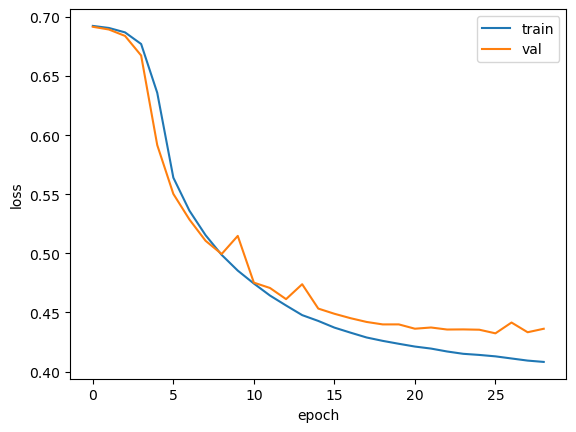

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 순환층에 드롭아웃 적용하기

In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(input_dim=500, output_dim=16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/home/leejieun/miniforge3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:82: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5183 - loss: 0.6929 - val_accuracy: 0.5642 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5638 - loss: 0.6922 - val_accuracy: 0.6076 - val_loss: 0.6913
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6012 - loss: 0.6906 - val_accuracy: 0.6452 - val_loss: 0.6878
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6364 - loss: 0.6855 - val_accuracy: 0.6888 - val_loss: 0.6708
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6706 - loss: 0.6603 - val_accuracy: 0.6870 - val_loss: 0.6284
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6910 - loss: 0.6261 - val_accuracy: 0.7024 - val_loss: 0.6141
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7096 - loss: 0.6075 - val_accuracy: 0.7268 - val_loss: 0.5945
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7316 - loss: 0.5890 -

드롭아웃의 효과가 나타난다. 훈련 검증 손실 간의 차이가 줄어듦을 확인

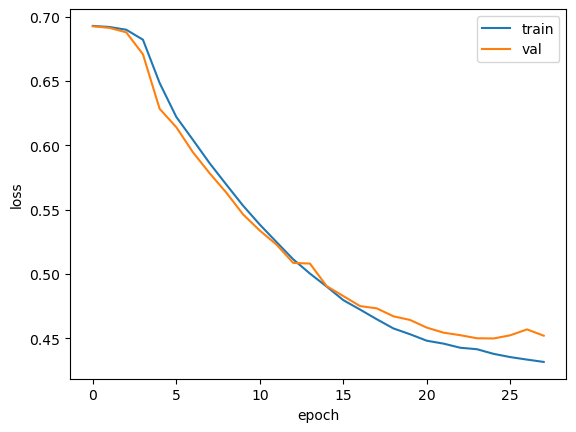

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층을 연결하기
마지막을 제외한 다른 모든 순환충에서 return_sequences 매개변수를 True 지정

In [13]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(input_dim=500, output_dim=16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, recurrent_dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, recurrent_dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

/home/leejieun/miniforge3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:82: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


두번째 LSTM 층에서는 마지막 타입스텝의 은닉상태만 출력하기 때문에 (None, 8)

In [14]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5067 - loss: 0.6931 - val_accuracy: 0.5016 - val_loss: 0.6930
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5204 - loss: 0.6929 - val_accuracy: 0.5630 - val_loss: 0.6925
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5649 - loss: 0.6923 - val_accuracy: 0.6124 - val_loss: 0.6912
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6037 - loss: 0.6905 - val_accuracy: 0.6486 - val_loss: 0.6864
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6389 - loss: 0.6825 - val_accuracy: 0.6666 - val_loss: 0.6658
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6651 - loss: 0.6520 - val_accuracy: 0.6828 - val_loss: 0.6260
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.6966 - loss: 0.6122 - val_accuracy: 0.7090 - val_loss: 0.5935
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7175 - loss: 0.59

과대적합을 제어하면서 손실을 최대한 낮춤

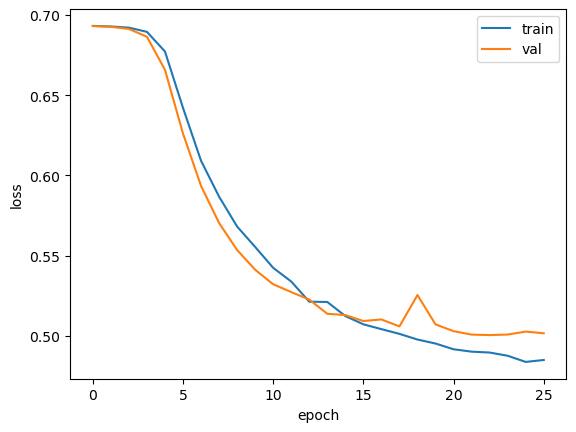

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### GRU 신경망 훈련하기
Gated Recurrent Unit 약자 / LSTM 간소화 버전

In [17]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(input_dim=500, output_dim=16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

/home/leejieun/miniforge3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:82: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### (16*8) + (8*8) + 8 + (3*8) 
작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런에 곱해지므로 24개가 추가되어 624개의 파라미터 생성

In [18]:
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5150 - loss: 0.6926 - val_accuracy: 0.5664 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5733 - loss: 0.6901 - val_accuracy: 0.5854 - val_loss: 0.6885
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5963 - loss: 0.6870 - val_accuracy: 0.5816 - val_loss: 0.6850
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6005 - loss: 0.6827 - val_accuracy: 0.5938 - val_loss: 0.6799
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6112 - loss: 0.6763 - val_accuracy: 0.6036 - val_loss: 0.6736
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6243 - loss: 0.6687 - val_accuracy: 0.6112 - val_loss: 0.6655
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6334 - loss: 0.6587 - val_accuracy: 0.6144 - val_loss: 0.6558
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6421 - loss: 0.646

드롭아웃을 사용하지 않았기에 과대적합이 있지만 훈련 과정이 잘 수렴되고 있다

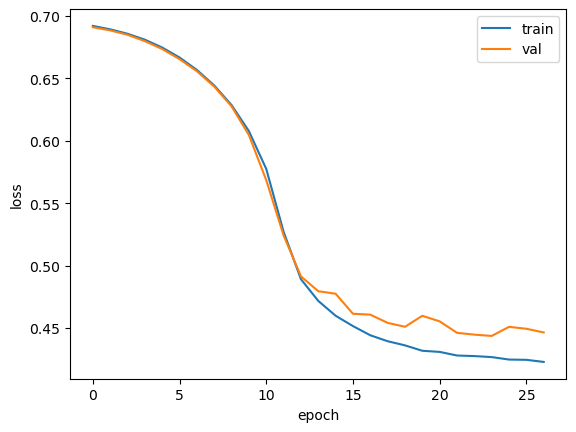

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### LSTM 과 GRU 셀로 훈련
가장 좋았던 2개의 순환층을 쌓은 모델을 다시 로드하여 테스트 세트에 대한 성능 확인해보기
- 결과 값: 모델은 드롭아웃으로 과대적합을 잘 억제했기 때문에 검증 세트와 크게 차이가 없는 성능 

In [21]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.keras')
rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7670 - loss: 0.4940


[0.4922512173652649, 0.7670800089836121]